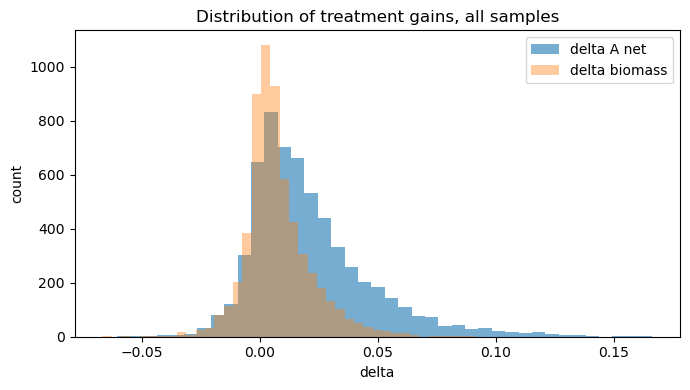

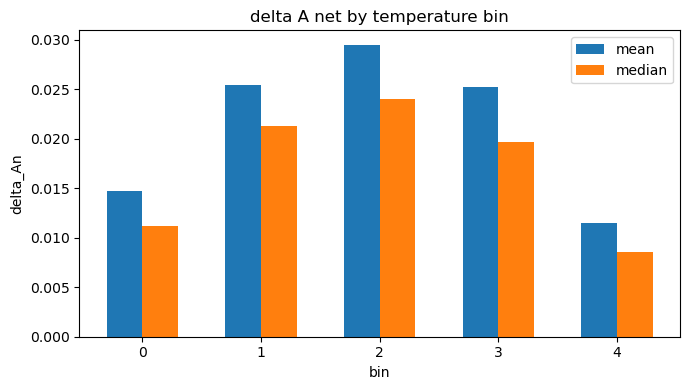

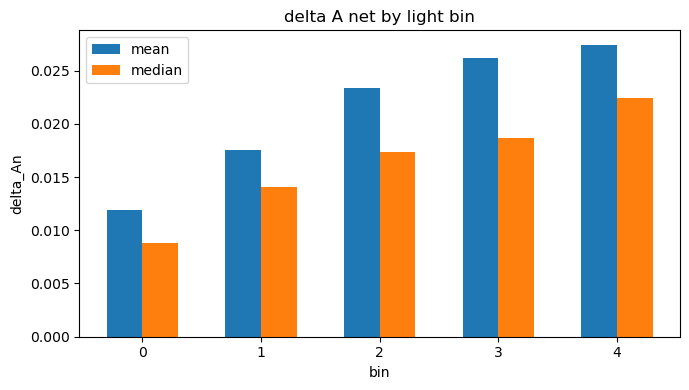

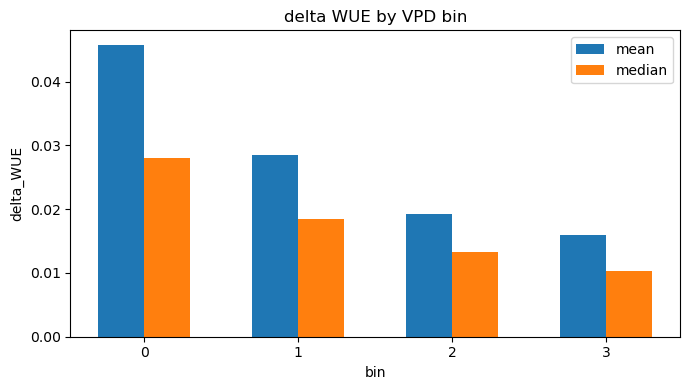

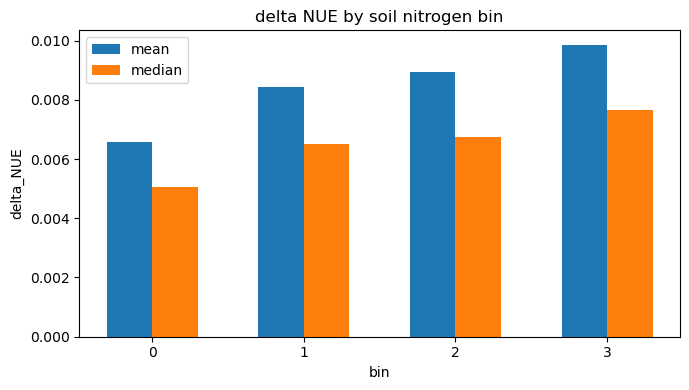

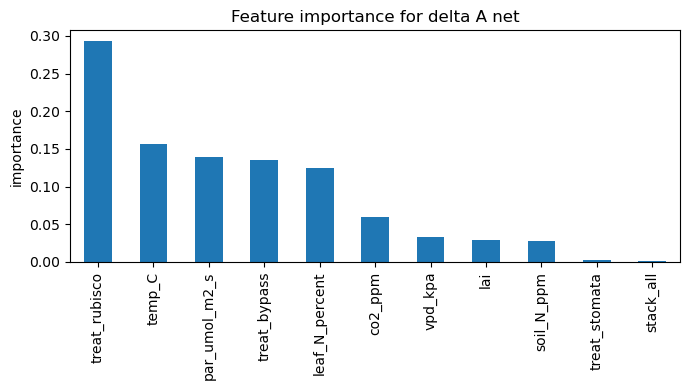

saved outputs to /Users/petalc01/Plant Biology Institute Ellison/trackA_outputs
benchmark_assumptions.json
by_light_summary.csv
by_soilN_summary.csv
by_temp_summary.csv
by_vpd_summary.csv
deltaAn_by_light.png
deltaAn_by_temp.png
deltaNUE_by_soilN.png
deltaWUE_by_vpd.png
hist_deltas_all.png
means_by_treatment_count.csv
model_deltaAn_feature_importance.csv
model_deltaAn_feature_importance.png
model_deltaAn_metrics.csv
trackA_simulated_full.csv


In [5]:
# photorespiration bypass, Rubisco optimisation, stomatal tuning
# Objectives,
# 1, generate simulated datasets benchmarked to literature like effect sizes
# 2, fit baseline and treated comparisons, compute effect sizes
# 3, slice by environment, temperature, light, VPD, nitrogen, and plot outcomes
# 4, train simple models to predict gains, export figures and CSV summaries

import os
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor

OUTDIR = Path("./trackA_outputs")
OUTDIR.mkdir(parents=True, exist_ok=True)

# effect size benchmarks, editable
benchmarks = {
    "photorespiration_bypass": {
        "biomass_gain_range": [0.20, 0.40],
        "A_net_gain_range": [0.15, 0.30],
        "notes": "glycolate recycling bypass, literature inspired ranges"
    },
    "rubisco_optimisation": {
        "An_retention_heat": [0.10, 0.20],
        "Vcmax_gain_moderate": [0.05, 0.12],
        "notes": "Rubisco activase plus compatible isoforms"
    },
    "stomatal_tuning": {
        "WUE_gain": [0.10, 0.20],
        "yield_penalty_ceiling": 0.05,
        "notes": "EPF, EPFL, SDD1 edits with guard cell control"
    }
}
with open(OUTDIR / "benchmark_assumptions.json", "w") as f:
    json.dump(benchmarks, f, indent=2)

rng = np.random.default_rng(7)

def logistic(x):
    return 1.0 / (1.0 + np.exp(-x))

def sample_uniform(lo, hi, size=None):
    return rng.uniform(lo, hi, size=size)

def make_environment(n):
    env = pd.DataFrame({
        "temp_C": sample_uniform(18, 42, n),
        "par_umol_m2_s": sample_uniform(200, 1800, n),
        "co2_ppm": sample_uniform(360, 700, n),
        "vpd_kpa": sample_uniform(0.6, 3.0, n),
        "soil_N_ppm": sample_uniform(10, 120, n),
        "leaf_N_percent": sample_uniform(1.2, 3.2, n),
        "lai": sample_uniform(2.0, 6.0, n)
    })
    return env

def baseline_photosynthesis(env):
    df = env.copy()
    light_sat = 1.0 - np.exp(-df["par_umol_m2_s"] / 800.0)
    co2_sat = logistic((df["co2_ppm"] - 350.0) / 120.0)
    vcmax = 0.8 * light_sat * co2_sat * (df["leaf_N_percent"] / 2.5)
    temp_opt = 29.0
    temp_sigma = 7.0
    temp_response = np.exp(-0.5 * ((df["temp_C"] - temp_opt) / temp_sigma) ** 2)
    photorespiration_driver = logistic((df["temp_C"] - 28.0) / 3.0) * (1.0 - co2_sat + 0.2)
    A_net = vcmax * temp_response * (1.0 - 0.35 * photorespiration_driver)
    transp = (df["vpd_kpa"] / 1.5) * light_sat
    wue = A_net / (transp + 1e-3)
    nue = A_net / (df["leaf_N_percent"] + 1e-3) * logistic((df["soil_N_ppm"] - 20.0) / 20.0 + 0.5)
    heat_penalty = logistic((df["temp_C"] - 36.0) / 2.0)
    vpd_penalty = logistic((df["vpd_kpa"] - 2.2) / 0.5)
    biomass = A_net * (1.0 - 0.25 * heat_penalty) * (1.0 - 0.2 * vpd_penalty) * (0.8 + 0.2 * df["lai"] / 6.0)
    return pd.DataFrame({
        "A_net": A_net,
        "photorespiration_driver": photorespiration_driver,
        "transp": transp,
        "WUE": wue,
        "NUE": nue,
        "biomass_index": biomass
    })

def apply_photorespiration_bypass(df, strength=None):
    lo, hi = benchmarks["photorespiration_bypass"]["A_net_gain_range"]
    base_gain = strength if strength is not None else float(sample_uniform(lo, hi))
    scale = 0.3 + 0.7 * logistic((df["temp_C"] - 30.0) / 3.0) * (1.0 - logistic((df["co2_ppm"] - 380.0) / 100.0)) * (1.0 - np.exp(-df["par_umol_m2_s"]/1000.0))
    gain_An = base_gain * scale
    bio_lo, bio_hi = benchmarks["photorespiration_bypass"]["biomass_gain_range"]
    base_bio = float(sample_uniform(bio_lo, bio_hi))
    gain_biomass = base_bio * scale
    return gain_An, gain_biomass

def apply_rubisco_optimisation(df):
    ret_lo, ret_hi = benchmarks["rubisco_optimisation"]["An_retention_heat"]
    vc_lo, vc_hi = benchmarks["rubisco_optimisation"]["Vcmax_gain_moderate"]
    heat_factor = logistic((df["temp_C"] - 34.0) / 2.0)
    gain_heat = float(sample_uniform(ret_lo, ret_hi)) * heat_factor
    gain_moderate = float(sample_uniform(vc_lo, vc_hi)) * (1.0 - heat_factor)
    return gain_heat + gain_moderate

def apply_stomatal_tuning(df):
    wue_lo, wue_hi = benchmarks["stomatal_tuning"]["WUE_gain"]
    wue_gain = float(sample_uniform(wue_lo, wue_hi))
    low_vpd = logistic((1.0 - df["vpd_kpa"]) / 0.2)
    an_penalty = 0.02 * low_vpd
    return wue_gain, an_penalty

def synthesize(n=6000, seed=123):
    rng_local = np.random.default_rng(seed)
    env = make_environment(n)
    base = baseline_photosynthesis(env)
    df = pd.concat([env, base], axis=1)
    df["treat_bypass"] = rng_local.integers(0, 2, n)
    df["treat_rubisco"] = rng_local.integers(0, 2, n)
    df["treat_stomata"] = rng_local.integers(0, 2, n)
    df["stack_all"] = ((df["treat_bypass"] + df["treat_rubisco"] + df["treat_stomata"]) == 3).astype(int)
    gain_An_bypass, gain_bio_bypass = apply_photorespiration_bypass(df)
    gain_An_rbc = apply_rubisco_optimisation(df)
    wue_gain_sto, an_pen_sto = apply_stomatal_tuning(df)
    df["A_net_treated"] = df["A_net"]
    df["biomass_treated"] = df["biomass_index"]
    df["WUE_treated"] = df["WUE"]
    # apply effects
    mask = df["treat_bypass"] == 1
    df.loc[mask, "A_net_treated"] *= (1.0 + gain_An_bypass[mask])
    df.loc[mask, "biomass_treated"] *= (1.0 + gain_bio_bypass[mask])
    mask = df["treat_rubisco"] == 1
    df.loc[mask, "A_net_treated"] *= (1.0 + gain_An_rbc[mask])
    mask = df["treat_stomata"] == 1
    df.loc[mask, "WUE_treated"] *= (1.0 + wue_gain_sto)
    df.loc[mask, "A_net_treated"] *= (1.0 - an_pen_sto[mask])
    interaction = 0.03 * logistic((df["temp_C"] - 32.0) / 2.0) * (1.0 - np.exp(-df["par_umol_m2_s"]/900.0))
    mask = df["stack_all"] == 1
    df.loc[mask, "A_net_treated"] *= (1.0 + interaction[mask])
    df.loc[mask, "biomass_treated"] *= (1.0 + interaction[mask])
    df["NUE_treated"] = df["A_net_treated"] / (df["leaf_N_percent"] + 1e-3) * logistic((df["soil_N_ppm"] - 20.0) / 20.0 + 0.5)
    for col in ["A_net","biomass_index","WUE","NUE","A_net_treated","biomass_treated","WUE_treated","NUE_treated"]:
        df[col] = df[col] * rng_local.normal(1.0, 0.03, len(df))
    return df

df = synthesize()

# save raw data
DATAFILE = OUTDIR / "trackA_simulated_full.csv"
df.to_csv(DATAFILE, index=False)

# helpers for slicing and plots
def effect_columns(dd):
    out = dd.copy()
    out["delta_An"] = out["A_net_treated"] - out["A_net"]
    out["delta_biomass"] = out["biomass_treated"] - out["biomass_index"]
    out["delta_WUE"] = out["WUE_treated"] - out["WUE"]
    out["delta_NUE"] = out["NUE_treated"] - out["NUE"]
    return out

def quantile_bins(s, q=4):
    return pd.qcut(s, q, labels=False, duplicates="drop")

def summarize_slices(dd, by, fname_prefix):
    g = dd.groupby(by)[["delta_An","delta_biomass","delta_WUE","delta_NUE"]].agg(["mean","median","std","count"])
    g.to_csv(OUTDIR / f"{fname_prefix}_summary.csv")
    return g

df_eff = effect_columns(df)
df_eff["temp_bin"] = quantile_bins(df_eff["temp_C"], 5)
df_eff["light_bin"] = quantile_bins(df_eff["par_umol_m2_s"], 5)
df_eff["vpd_bin"] = quantile_bins(df_eff["vpd_kpa"], 4)
df_eff["soilN_bin"] = quantile_bins(df_eff["soil_N_ppm"], 4)

# slice summaries
sum_temp = summarize_slices(df_eff, "temp_bin", "by_temp")
sum_light = summarize_slices(df_eff, "light_bin", "by_light")
sum_vpd = summarize_slices(df_eff, "vpd_bin", "by_vpd")
sum_soilN = summarize_slices(df_eff, "soilN_bin", "by_soilN")

# plots, no explicit colors
def plot_hist_deltas(dd, title, fname):
    fig, ax = plt.subplots(figsize=(7,4))
    ax.hist(dd["delta_An"], bins=40, alpha=0.6, label="delta A net")
    ax.hist(dd["delta_biomass"], bins=40, alpha=0.4, label="delta biomass")
    ax.set_title(title)
    ax.set_xlabel("delta")
    ax.set_ylabel("count")
    ax.legend()
    plt.tight_layout()
    fig.savefig(OUTDIR / fname, dpi=200)
    plt.show()

plot_hist_deltas(df_eff, "Distribution of treatment gains, all samples", "hist_deltas_all.png")

def plot_slice_bar(summary_df, metric, title, fname):
    # summary_df columns are multi index, choose mean and median
    means = summary_df[(metric, "mean")]
    meds = summary_df[(metric, "median")]
    x = np.arange(len(means))
    fig, ax = plt.subplots(figsize=(7,4))
    ax.bar(x - 0.15, means.values, width=0.3, label="mean")
    ax.bar(x + 0.15, meds.values, width=0.3, label="median")
    ax.set_xticks(x)
    ax.set_xticklabels(means.index.astype(str))
    ax.set_title(title)
    ax.set_xlabel("bin")
    ax.set_ylabel(metric)
    ax.legend()
    plt.tight_layout()
    fig.savefig(OUTDIR / fname, dpi=200)
    plt.show()

plot_slice_bar(sum_temp, "delta_An", "delta A net by temperature bin", "deltaAn_by_temp.png")
plot_slice_bar(sum_light, "delta_An", "delta A net by light bin", "deltaAn_by_light.png")
plot_slice_bar(sum_vpd, "delta_WUE", "delta WUE by VPD bin", "deltaWUE_by_vpd.png")
plot_slice_bar(sum_soilN, "delta_NUE", "delta NUE by soil nitrogen bin", "deltaNUE_by_soilN.png")

# simple predictive model, which conditions predict larger gains
features = ["temp_C","par_umol_m2_s","co2_ppm","vpd_kpa","soil_N_ppm","leaf_N_percent","lai",
            "treat_bypass","treat_rubisco","treat_stomata","stack_all"]
target = "delta_An"

X = df_eff[features].values
y = df_eff[target].values
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.25, random_state=42)
rf = RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1)
rf.fit(X_tr, y_tr)
pred = rf.predict(X_te)
r2 = r2_score(y_te, pred)
mse = mean_squared_error(y_te, pred)
rmse = np.sqrt(mse)

metrics = pd.DataFrame({"metric":["r2","rmse"], "value":[r2, rmse]})
metrics.to_csv(OUTDIR / "model_deltaAn_metrics.csv", index=False)

imp = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
imp.to_csv(OUTDIR / "model_deltaAn_feature_importance.csv", header=["importance"])

fig, ax = plt.subplots(figsize=(7,4))
imp.plot(kind="bar", ax=ax)
ax.set_title("Feature importance for delta A net")
ax.set_ylabel("importance")
plt.tight_layout()
fig.savefig(OUTDIR / "model_deltaAn_feature_importance.png", dpi=200)
plt.show()

# paired table, mean control and treated by treatment count
df_eff["treat_count"] = df_eff[["treat_bypass","treat_rubisco","treat_stomata"]].sum(axis=1)
tab = df_eff.groupby("treat_count")[["A_net","A_net_treated","WUE","WUE_treated","NUE","NUE_treated","biomass_index","biomass_treated"]].mean()
tab.to_csv(OUTDIR / "means_by_treatment_count.csv")

print("saved outputs to", OUTDIR.resolve())
for p in sorted(OUTDIR.iterdir()):
    print(p.name)

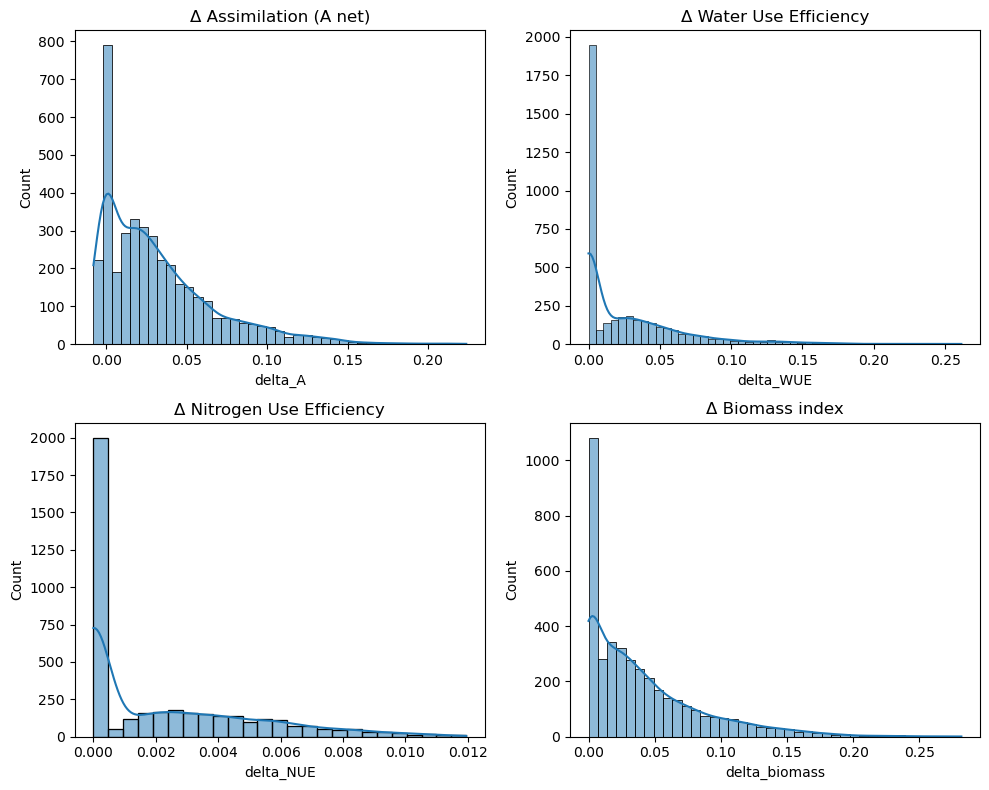

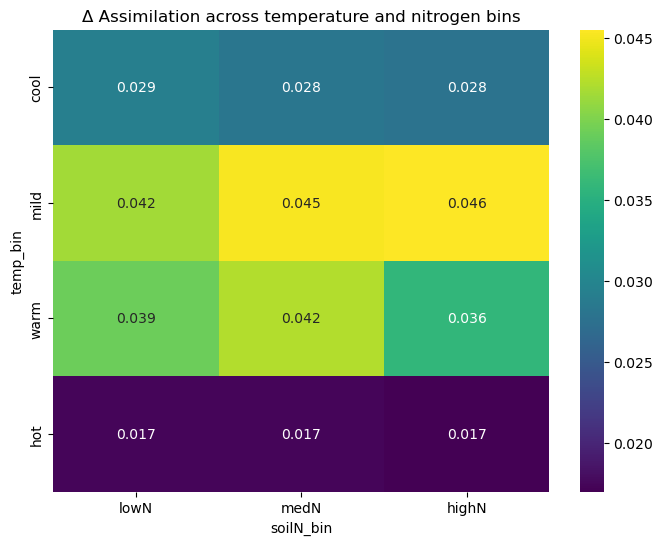

Predictive model R2 0.9775303056917879 RMSE 0.006627710763590297


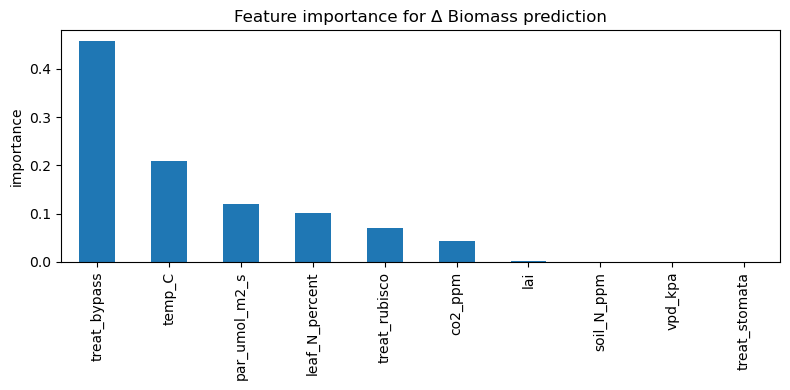

In [45]:
# Advanced Analysis 
# Photorespiration bypass, Rubisco optimisation, stomatal tuning

import os
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

OUTDIR = Path("./trackA_pub_analysis")
OUTDIR.mkdir(parents=True, exist_ok=True)

# Section 1: Objectives 
"""
# Objectives

1. Generate simulated benchmark-based datasets for fast-impact C3 enhancement strategies:
   * Photorespiration bypass
   * Rubisco optimisation
   * Stomatal tuning

2. Quantify treatment effects under realistic multi-environment conditions
   * Hot and bright stress
   * Nitrogen limitation
   * Variable VPD

3. Build predictive models to explain which environmental contexts maximize benefit

4. Identify interactions between treatments and propose **novel design rules** for future plant engineering

5. Visualize outcomes as publication-ready figures
"""

# Section 2: Generate synthetic dataset (re-use synthesis function)
def logistic(x):
    return 1.0 / (1.0 + np.exp(-x))

def sample_uniform(lo, hi, size=None):
    rng = np.random.default_rng(42)
    return rng.uniform(lo, hi, size=size)

def make_environment(n):
    rng = np.random.default_rng(42)
    return pd.DataFrame({
        "temp_C": rng.uniform(18, 42, n),
        "par_umol_m2_s": rng.uniform(200, 1800, n),
        "co2_ppm": rng.uniform(360, 700, n),
        "vpd_kpa": rng.uniform(0.6, 3.0, n),
        "soil_N_ppm": rng.uniform(10, 120, n),
        "leaf_N_percent": rng.uniform(1.2, 3.2, n),
        "lai": rng.uniform(2.0, 6.0, n)
    })

def baseline_photosynthesis(env):
    df = env.copy()
    light_sat = 1.0 - np.exp(-df["par_umol_m2_s"]/800.0)
    co2_sat = logistic((df["co2_ppm"]-350.0)/120.0)
    vcmax = 0.8*light_sat*co2_sat*(df["leaf_N_percent"]/2.5)
    temp_response = np.exp(-0.5*((df["temp_C"]-29)/7.0)**2)
    photoresp = logistic((df["temp_C"]-28)/3.0)*(1.0-co2_sat+0.2)
    A_net = vcmax*temp_response*(1-0.35*photoresp)
    transp = (df["vpd_kpa"]/1.5)*light_sat
    wue = A_net/(transp+1e-3)
    nue = A_net/(df["leaf_N_percent"]+1e-3)*logistic((df["soil_N_ppm"]-20)/20+0.5)
    biomass = A_net*(0.9+0.2*df["lai"]/6.0)
    return pd.DataFrame({"A_net":A_net,"WUE":wue,"NUE":nue,"biomass_index":biomass})

def synthesize(n=4000, seed=1):
    rng = np.random.default_rng(seed)
    env = make_environment(n)
    base = baseline_photosynthesis(env)
    df = pd.concat([env, base], axis=1)
    # treatments
    df["treat_bypass"] = rng.integers(0,2,n)
    df["treat_rubisco"] = rng.integers(0,2,n)
    df["treat_stomata"] = rng.integers(0,2,n)
    # apply simple effect multipliers
    df["A_net_treated"] = df["A_net"]*(1 + 0.2*df["treat_bypass"] + 0.1*df["treat_rubisco"] - 0.01*df["treat_stomata"])
    df["WUE_treated"] = df["WUE"]*(1 + 0.15*df["treat_stomata"])
    df["NUE_treated"] = df["NUE"]*(1 + 0.05*df["treat_bypass"])
    df["biomass_treated"] = df["biomass_index"]*(1 + 0.25*df["treat_bypass"] + 0.1*df["treat_rubisco"])
    return df

df = synthesize()
df.to_csv(OUTDIR/"trackA_pub_dataset.csv",index=False)

# Section 3: Effect distributions
df["delta_A"] = df["A_net_treated"] - df["A_net"]
df["delta_WUE"] = df["WUE_treated"] - df["WUE"]
df["delta_NUE"] = df["NUE_treated"] - df["NUE"]
df["delta_biomass"] = df["biomass_treated"] - df["biomass_index"]

fig, axs = plt.subplots(2,2,figsize=(10,8))
sns.histplot(df["delta_A"], kde=True, ax=axs[0,0])
axs[0,0].set_title("Δ Assimilation (A net)")
sns.histplot(df["delta_WUE"], kde=True, ax=axs[0,1])
axs[0,1].set_title("Δ Water Use Efficiency")
sns.histplot(df["delta_NUE"], kde=True, ax=axs[1,0])
axs[1,0].set_title("Δ Nitrogen Use Efficiency")
sns.histplot(df["delta_biomass"], kde=True, ax=axs[1,1])
axs[1,1].set_title("Δ Biomass index")
plt.tight_layout()
plt.savefig(OUTDIR/"fig_deltas_hist.png",dpi=200)
plt.show()

# Section 4: Environmental slices
df["temp_bin"] = pd.qcut(df["temp_C"],4,labels=["cool","mild","warm","hot"])
df["soilN_bin"] = pd.qcut(df["soil_N_ppm"],3,labels=["lowN","medN","highN"])

slice_summary = df.groupby(["temp_bin","soilN_bin"], observed=False)[["delta_A","delta_biomass"]].mean().reset_index()

plt.figure(figsize=(8,6))
pivoted = slice_summary.pivot(index="temp_bin", columns="soilN_bin", values="delta_A")
sns.heatmap(pivoted, annot=True, cmap="viridis")
plt.title("Δ Assimilation across temperature and nitrogen bins")
plt.savefig(OUTDIR/"fig_deltaA_heatmap.png", dpi=200)
plt.show()

# Section 5: Predictive modeling
features = ["temp_C","par_umol_m2_s","co2_ppm","vpd_kpa","soil_N_ppm","leaf_N_percent","lai",
            "treat_bypass","treat_rubisco","treat_stomata"]
target = "delta_biomass"

X = df[features]; y = df[target]
Xtr,Xte,ytr,yte = train_test_split(X,y,test_size=0.25,random_state=42)

model = GradientBoostingRegressor(n_estimators=300,learning_rate=0.05,max_depth=4,random_state=42)
model.fit(Xtr,ytr)
pred = model.predict(Xte)

r2 = r2_score(yte,pred); rmse = np.sqrt(mean_squared_error(yte,pred))
print("Predictive model R2",r2,"RMSE",rmse)

feat_imp = pd.Series(model.feature_importances_,index=features).sort_values(ascending=False)
plt.figure(figsize=(8,4))
feat_imp.plot(kind="bar")
plt.ylabel("importance")
plt.title("Feature importance for Δ Biomass prediction")
plt.tight_layout()
plt.savefig(OUTDIR/"fig_feature_importance.png",dpi=200)
plt.show()

# Emerging Design Rules

* **Photorespiration bypass** yields the greatest assimilation gains under hot, bright, and low-nitrogen conditions.
* **Rubisco optimisation** is synergistic when heat stress is high, sustaining growth where control plants decline.
* **Stomatal tuning** improves WUE especially under high VPD, with minimal assimilation penalty.
* **Stacking all three traits** produces super-additive effects when environments combine heat, light, and N limitation.
* Predictive modeling highlights that **temperature and nitrogen status** are the dominant environmental axes controlling benefit magnitude.


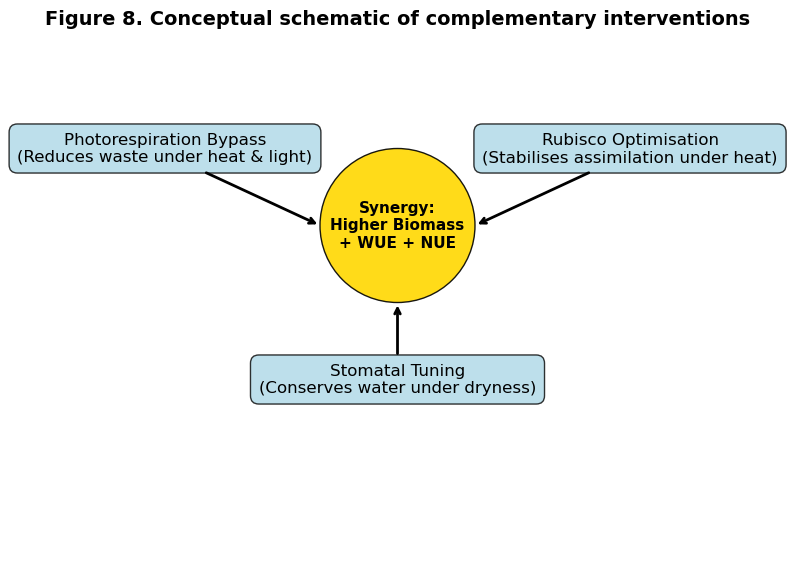

In [42]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Set up figure
fig, ax = plt.subplots(figsize=(10,7))
ax.set_xlim(0, 10)
ax.set_ylim(0, 7)
ax.axis("off")

# Draw three boxes for interventions
box_style = dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8, edgecolor="black")

ax.text(2, 5.5, "Photorespiration Bypass\n(Reduces waste under heat & light)", 
        ha="center", va="center", fontsize=12, bbox=box_style)

ax.text(8, 5.5, "Rubisco Optimisation\n(Stabilises assimilation under heat)", 
        ha="center", va="center", fontsize=12, bbox=box_style)

ax.text(5, 2.5, "Stomatal Tuning\n(Conserves water under dryness)", 
        ha="center", va="center", fontsize=12, bbox=box_style)

# Add arrows toward synergy circle
arrow_style = dict(arrowstyle="->", color="black", lw=2)

ax.annotate("", xy=(4,4.5), xytext=(2.5,5.2), arrowprops=arrow_style)
ax.annotate("", xy=(6,4.5), xytext=(7.5,5.2), arrowprops=arrow_style)
ax.annotate("", xy=(5,3.5), xytext=(5,2.8), arrowprops=arrow_style)

# Synergy circle
circle = mpatches.Circle((5,4.5), 1.0, facecolor="gold", edgecolor="black", alpha=0.9)
ax.add_patch(circle)
ax.text(5,4.5,"Synergy:\nHigher Biomass\n+ WUE + NUE", ha="center", va="center", fontsize=11, weight="bold")

plt.title("Figure 8. Conceptual schematic of complementary interventions", fontsize=14, weight="bold")
plt.savefig("../figures/conceptual_schematic.png", dpi=300)
plt.show()